<a href="https://colab.research.google.com/github/dpalominop/SistemasInteligentes/blob/master/semana15/homework/lstm-bi-text-generation-10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Generation using a Bidirectional LSTM Network

<br/>

## Loading Libraries and Parameters

In [2]:
from __future__ import print_function
#import Keras library
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
from keras.metrics import categorical_accuracy

import tensorflow as tf
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

#import spacy, and spacy french model
# spacy is used to work on text
#!pip install spacy
import spacy
#!python -m spacy download es
nlp = spacy.load('es')

#import other libraries
import numpy as np
import random
import sys
import os
import time
import codecs
import collections
from six.moves import cPickle
import pandas as pd

['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
#define parameters used in the tutorial
data_dir = 'data/'# data directory containing raw texts
save_dir = 'models/' # directory to store trained NN models
file_list = ["spanish_emojis"]
  
vocab_file = os.path.join(data_dir, "words_vocab.pkl")
words_list_file = os.path.join(data_dir, "words_list.pkl")
data_file = os.path.join(data_dir, file_list[0] + ".csv")
sequences_file = os.path.join(data_dir, "sequences_list.pkl")
next_words_file = os.path.join(data_dir, "next_words_list.pkl")

sequences_step = 1 #step to create sequences
seq_length = 10 # sequence length
preprocess = False
training = True

<br/>

## PreProcessing the Data

In [4]:
def read_file(filename):
    items = []
    if os.path.exists(filename):
        # try:
        with open(filename, 'rb') as fname:
            while True:
                try:
                    items = cPickle.load(fname)
                except EOFError:
                    print(EOFError)
                    break
    else:
        items = []
    
    return items

In [5]:
def create_wordlist(doc):
    wl = []
    for word in doc:
        if word.text not in ("\n","\n\n",'\u2009','\xa0'):
            wl.append(word.text.lower())
    return wl

In [6]:
sequences = []
next_words = []
wordlist = []
if(preprocess):
    input_file = pd.read_csv(data_file)
    lines = input_file['observations']
    for data in lines:
        #create sentences
        doc = nlp(data)
        wl = create_wordlist(doc)
        wordlist = wordlist + wl
        if(len(wl) < 2): 
            continue
        seq = [' ' for i in range(seq_length - len(wl) + 1)]
        seq = seq + wl

        for i in range(0, len(seq) - seq_length, sequences_step):
          sequences.append(seq[i: i + seq_length])
          next_words.append(seq[i + seq_length])

In [7]:
if(preprocess):
    # count the number of words
    word_counts = collections.Counter(wordlist)

    # Mapping from index to word : that's the vocabulary
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary_inv = list(sorted(vocabulary_inv))

    # Mapping from word to index
    vocab = {x: i for i, x in enumerate(vocabulary_inv)}
    words = [x[0] for x in word_counts.most_common()]

    #size of the vocabulary
    vocab_size = len(words)
    print("vocab size: ", vocab_size)

    #save the words and vocabulary
    with open(os.path.join(vocab_file), 'wb') as f:
        cPickle.dump((words, vocab, vocabulary_inv), f)
    with open(os.path.join(words_list_file), 'wb') as f:
        cPickle.dump((wordlist), f)
    with open(os.path.join(sequences_file), 'wb') as f:
        cPickle.dump((sequences), f)
    with open(os.path.join(next_words_file), 'wb') as f:
        cPickle.dump((next_words), f)

In [8]:
if(not preprocess):
    wordlist = read_file(words_list_file)
    (words, vocab, vocabulary_inv) = read_file(vocab_file)
    sequences = read_file(sequences_file)
    next_words = read_file(next_words_file)
    
    # count the number of words
    word_counts = collections.Counter(wordlist)
    
    #size of the vocabulary
    vocab_size = len(words)
    print("vocab size: ", vocab_size)

<class 'EOFError'>
<class 'EOFError'>
<class 'EOFError'>
<class 'EOFError'>
vocab size:  66846


In [9]:
print('nb sequences: ', len(sequences))

nb sequences:  421621


<br/>

## Building the Model

In [10]:
def bidirectional_lstm_model(seq_length, vocab_size):
    print('Build LSTM model.')
    model = Sequential()
    model.add(Bidirectional(LSTM(rnn_size, activation="relu"),input_shape=(seq_length, vocab_size)))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    
    optimizer = Adam(lr=learning_rate)
    callbacks=[EarlyStopping(patience=2, monitor='val_loss')]
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])
    return model

In [11]:
rnn_size = 40 # size of RNN
batch_size = 32 # minibatch size
seq_length = 10 # sequence length
num_epochs = 20 # number of epochs
learning_rate = 0.01 #learning rate
sequences_step = 1 #step to create sequences
BATCH_GEN = 100

In [12]:
md = bidirectional_lstm_model(seq_length, vocab_size)
md.summary()

Build LSTM model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 80)                21403840  
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 66846)             5414526   
_________________________________________________________________
activation_1 (Activation)    (None, 66846)             0         
Total params: 26,818,366
Trainable params: 26,818,366
Non-trainable params: 0
_________________________________________________________________


<br/>

## Training the Model

In [13]:
def generator(sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, seq_length, len(words)), dtype=np.bool)
        y = np.zeros((batch_size, len(words)), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index]):
                x[i, t, vocab[w]] = 1
            y[i, vocab[next_words[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
        yield x, y

In [14]:
file_path = "BI-LSTM-epoch{epoch:03d}-words%d-sequence%d" % (
    len(words),
    seq_length
)

checkpoint = ModelCheckpoint(os.path.join(save_dir, file_path), monitor='categorical_accuracy', save_best_only=True)

#print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=5)
callbacks_list = [checkpoint, 
                  #print_callback, 
                  early_stopping]

In [15]:
history = []
#if(training):
with tf.device('/device:GPU:2'):
    history = md.fit_generator(
    generator(sequences[:10000], next_words[:10000], BATCH_GEN),
    steps_per_epoch=int(len(sequences[:10000])/BATCH_GEN) + 1,
    epochs=num_epochs,
    callbacks=callbacks_list,
    #validation_split=0.02,
    #shuffle=True,
    #validation_data=generator(sentences_test, next_words_test, BATCH_SIZE),
    #validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1)
    )

Epoch 1/20
101/101 [==============================] - 76s 749ms/step - loss: 8.5630 - categorical_accuracy: 0.0236
Epoch 2/20
101/101 [==============================] - 70s 692ms/step - loss: 7.0832 - categorical_accuracy: 0.0272
Epoch 3/20
101/101 [==============================] - 70s 689ms/step - loss: 6.6337 - categorical_accuracy: 0.0397
Epoch 4/20
101/101 [==============================] - 69s 687ms/step - loss: 6.2011 - categorical_accuracy: 0.0554
Epoch 5/20
101/101 [==============================] - 69s 687ms/step - loss: 5.7995 - categorical_accuracy: 0.0775
Epoch 6/20
101/101 [==============================] - 70s 691ms/step - loss: 5.3744 - categorical_accuracy: 0.1032
Epoch 7/20
101/101 [==============================] - 70s 691ms/step - loss: 4.8181 - categorical_accuracy: 0.1414
Epoch 8/20
101/101 [==============================] - 70s 692ms/step - loss: 4.2414 - categorical_accuracy: 0.1802
Epoch 9/20
101/101 [==============================] - 70s 690ms/step - loss: 3.7

In [16]:
if(training):
    #save the model
    md.save(os.path.join(save_dir,  'gen_sentences_bi_lstm_10k_s10.final.hdf5'))

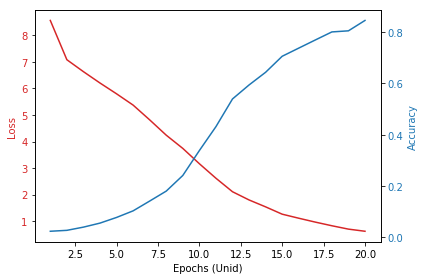

In [82]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 21, 1)
loss = [8.5630, 7.0832, 6.6337, 6.2061, 5.7995, 5.3744, 4.8181, 4.2414, 3.7431, 3.1664, 2.6202, 2.1116, 1.8020, 1.5416, 1.2661, 1.114, 0.9676, 0.8303, 0.7034, 0.6229]
acc  = [0.0236, 0.0272, 0.0397, 0.0554, 0.0775, 0.1032, 0.1414, 0.1802, 0.2412, 0.3383, 0.4315, 0.5395, 0.5941, 0.6436, 0.7060, 0.7378, 0.7695, 0.8009, 0.8052, 0.8457]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs (Unid)')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(epochs, acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<br/>

## Testing the Model

In [7]:
import os
from six.moves import cPickle
import numpy as np

data_dir = 'data/'# data directory containing raw texts
save_dir = 'models/' # directory to store trained NN models
vocab_file = os.path.join(data_dir, "words_vocab.pkl")
seq_length = 10 # sequence length

#load vocabulary
print("loading vocabulary...")

with open(vocab_file, 'rb') as f:
        words, vocab, vocabulary_inv = cPickle.load(f)

vocab_size = len(words)

loading vocabulary...


In [3]:
from keras.models import load_model
# load the model
print("loading model...")
model = load_model(save_dir + "/" + 'gen_sentences_bi_lstm_10k_s10.final.hdf5')

Using TensorFlow backend.


loading model...


In [4]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [80]:
#initiate sentences
#seed_sentences = "estoy muy cansado para estudiar hoy"
#seed_sentences = "todos vamos"
#seed_sentences = "hola amigos"
seed_sentences = "estoy vivo jaja"

generated = ''
sentence = []
for i in range (seq_length):
    sentence.append(".")

seed = seed_sentences.split()

for i in range(len(seed)):
    sentence[seq_length-i-1]=seed[len(seed)-i-1]

generated += ' '.join(sentence)
print('Generating text with the following seed: "' + ' '.join(sentence) + '"')

print ()

Generating text with the following seed: ". . . . . . . estoy vivo jaja"



In [81]:
words_number = 10
#generate the text
for i in range(words_number):
    #create the vector
    x = np.zeros((1, seq_length, vocab_size))
    for t, word in enumerate(sentence):
        x[0, t, vocab[word]] = 1.
    #print(x.shape)

    #calculate next word
    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, 0.34)
    next_word = vocabulary_inv[next_index]

    #add the next word to the text
    generated += " " + next_word
    # shift the sentence by one, and and the next word at its end
    sentence = sentence[1:] + [next_word]

print(generated)

D:\opt\Anaconda3\envs\SI\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


. . . . . . . estoy vivo jaja si me va a la serie a la 3 am
